In [1]:
import os 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pal = sns.color_palette()

In [92]:
train_data = pd.read_csv('../Data/train_dataset_random_negative_sample_from_iteself.csv')
evaluation_data = pd.read_csv('../Data/evaluation.csv')

In [93]:
print("=> Train Data:")
train_data.head()

=> Train Data:


,Unnamed: 0,text,reason,label
0,0,when entering a conference or moving to the se...,24mb zoom emojis are downloaded all the time,1
1,1,"when notifications are received on the phone, ...",notifications are received on the phone,1
2,2,"it fails a lot, i have to delete and re-downlo...",presentation is slow,0
3,3,i think this app must be modified the camera q...,want to modify camera quality,1
4,4,"""wrong conference code"", although everything g...",getting wrong conference code,1


In [94]:
print("=> Evaluation Data:")
evaluation_data.head()

=> Evaluation Data:


,text,reason,label
0,the app is crashing when i play a vedio,app crashes during playback,1
1,but i want to connect it to the tv from one de...,want compatibility with more smart televisions,0
2,very helpful when and home working remotley,good app for work,0
3,this zoom so called and missed call and mobile...,receiving incorrect phone number message,0
4,one of my favorite apps,good for spending time,0


In [95]:
train_data.shape

(2061, 4)

In [96]:
evaluation_data.shape

(9000, 3)

In [97]:
evaluation_data[evaluation_data['label'] == 0].shape

(5999, 3)

In [98]:
9000 - 5999

3001

## **Dataset information**

- The CSV files have 3 columns
    - text
    - reason: a short description
    - label:
        - 0: text and reason **do not** match with each other
        - 1: text and reason match with each other
- The dataset has been cleaned to a certain extent. You can probe more.

### Some Notes

- All the examples are positive examples, which means we need to generate some negative examples such that the 
the distribution of +ve/-ve remains same. 

- Further cleaning of the text and checking duplicates. 

In [99]:
# Finding duplicates 

duplicates = train_data[train_data.duplicated()]
duplicates

,Unnamed: 0,text,reason,label


We can Assume that there are no duplicates present in our data. 

### General overview of the overall procedure

- The type of problem is a **Binary Classification problem**


- I will start to see the **textual distribution similarity** between train and test set. This is important to check and predict whether our model will work perfectly during Testing or not. We will do this by checking:
    - Character level distribution check 
    - Word level distribution check 

- Next we will move forward for some scemantic analysis for feature analysis. 


- Then we come to an important part which is building the actual dataset. The main focussing point of this whole task is to introduce negative samples. Otherwise the existing dataset will not make sense. We can solve this problem in two-three potential ways:

    - Suppose we have rows 1,2,3 all with label 1. Now we put the "reason" of row 3 to row 1, row 1 to row 2 and so on, to sample negative samples. This approach might be a great starter, but might not be accurate. 
    
    - In the 2nd approach we can do the same thing as 1, but instead of random deterministic way. We first get the features of each questions and reason. Now for each question we sample the most distant/nearly distant feature vector for the "reason", so that the model can get better feature for classifying -ve samples. 
    
    - Finally we can use a pre-trained BERT model for generating negative samples for a given question. [Ref from paper](https://aclanthology.org/2021.naacl-main.120.pdf)
    
    - Even I can use a BERT-BASE-UNCASED model and put some random [MASK] token and generate some **LOW** Conf tokens to fill out the mask and that would be considered as a -ve sample [Ref](https://huggingface.co/bert-base-uncased)

- Once we build our dataset, then we need to train our model for scemantic similarity. We can do this by using 
    - XG Boost 
    - A pretrained BERT 
    

- Finally we are left to finetune more if possible and get our final results.

### Analysis

#### Textual distribution similarity

In [55]:
eval_frac = evaluation_data.sample(3000)

In [56]:
train_qna = pd.Series(
    train_data['text'].tolist() + train_data['reason'].tolist()
).astype(str)

evaluation_qna = pd.Series(
    eval_frac['text'].tolist() + eval_frac['reason'].tolist()
).astype(str)

In [57]:
def normalize_df(df):
    return (df - df.min()) / (df.max() - df.min())

In [58]:
def plot_histogram(df, color, label, alpha=0.5):
    x,y=[],[]
    for index, element in df.items():
        x.append(index)
        y.append(element)
    plt.plot(x, y, color=color, label=label, alpha=alpha)

In [59]:
train_dist = train_qna.apply(len)
evaluation_dist = evaluation_qna.apply(len)

Text(0, 0.5, 'Probability')

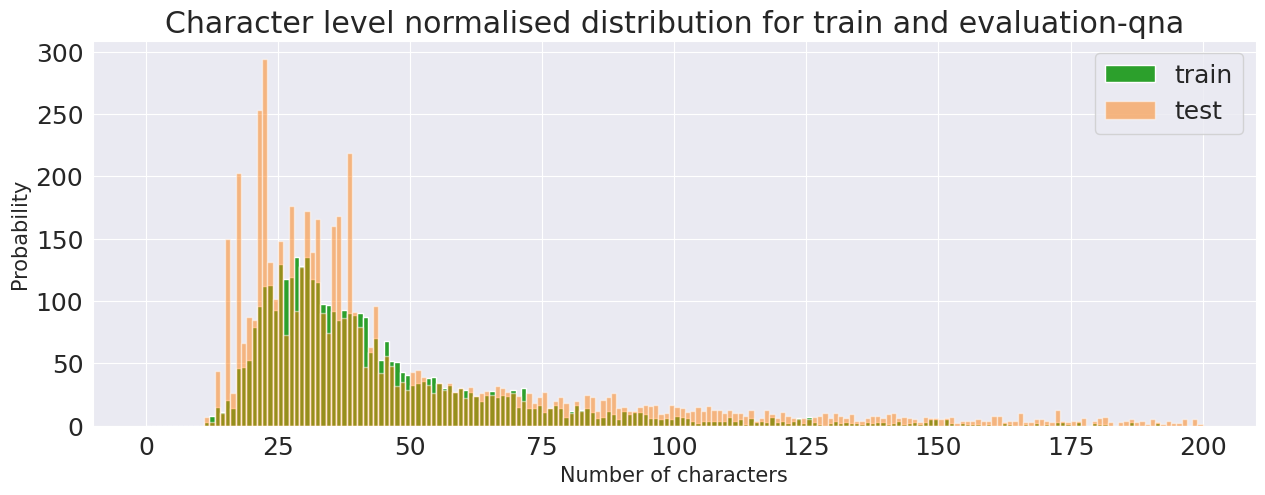

In [60]:
plt.figure(figsize=(15, 5))
plt.hist(
    train_dist, bins=200, range=[0, 200], color=pal[2], label='train',
)

plt.hist(
    evaluation_dist, bins=200, range=[0, 200], color=pal[1], alpha=0.5, label='test'
)

plt.title('Character level normalised distribution for train and evaluation-qna')
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

#### Word level histogram

In [61]:
word_level_train_dist = train_qna.apply(
    lambda x : len(x.split(' '))
)

word_level_evaluation_dist = evaluation_qna.apply(
    lambda x : len(x.split(' '))
)

Text(0, 0.5, 'Probability')

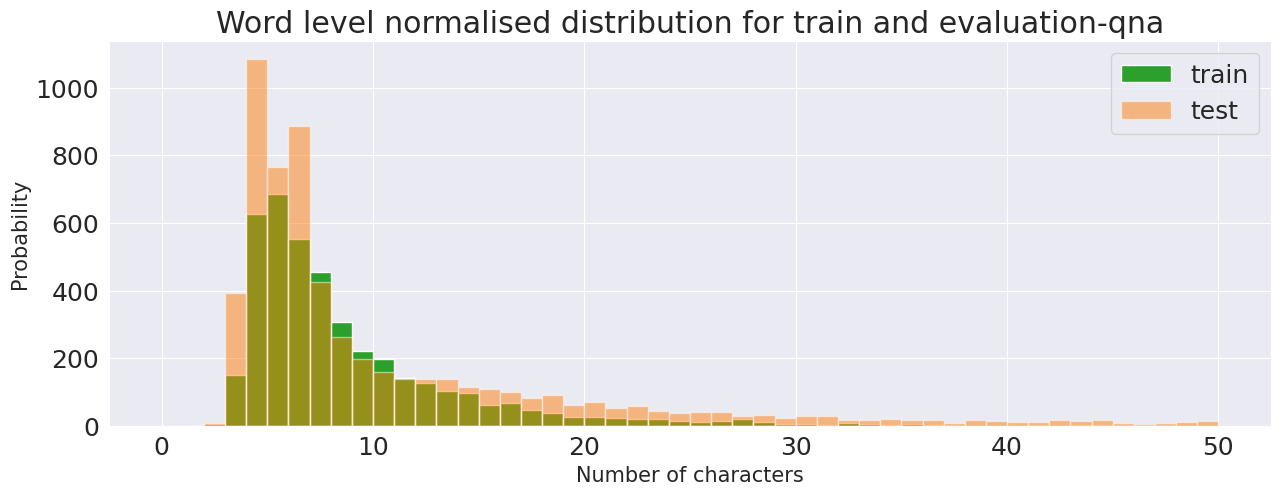

In [62]:
plt.figure(figsize=(15, 5))
plt.hist(
    word_level_train_dist, bins=50, range=[0, 50], color=pal[2], label='train',
)

plt.hist(
    word_level_evaluation_dist, bins=50, range=[0, 50], 
    color=pal[1], alpha=0.5, label='test'
)

plt.title('Word level normalised distribution for train and evaluation-qna')
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

TODO: Apply Normalization for these graphs

#### Inference

The character and word level distribution are similar to each other and sort of skewed. Although the width of the distribution is same, the height of test dist is > height of train.

**Pointers**

- For **Character level distribution** The **Train dist**, most questions ranges between 15-75 characters. Where as the the **Evaluation dist** most question ranges 15-120 characters long. 


- Similarly for **Word level distribution**, The **Train dist**, questions are about 5 to 15 words long where as the **Evaluation dist**, it is arounf 25 words long, similar to the behaviour of character level distribution

In [63]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('omw-1.4')
tqdm.pandas()
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package omw-1.4 to /home/anindya/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anindya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
from wordcloud import WordCloud

In [65]:
all_train_text = pd.Series(train_data['text'].to_list() + 
                  train_data['reason'].to_list()).astype(str)

(-0.5, 1439.5, 1079.5, -0.5)

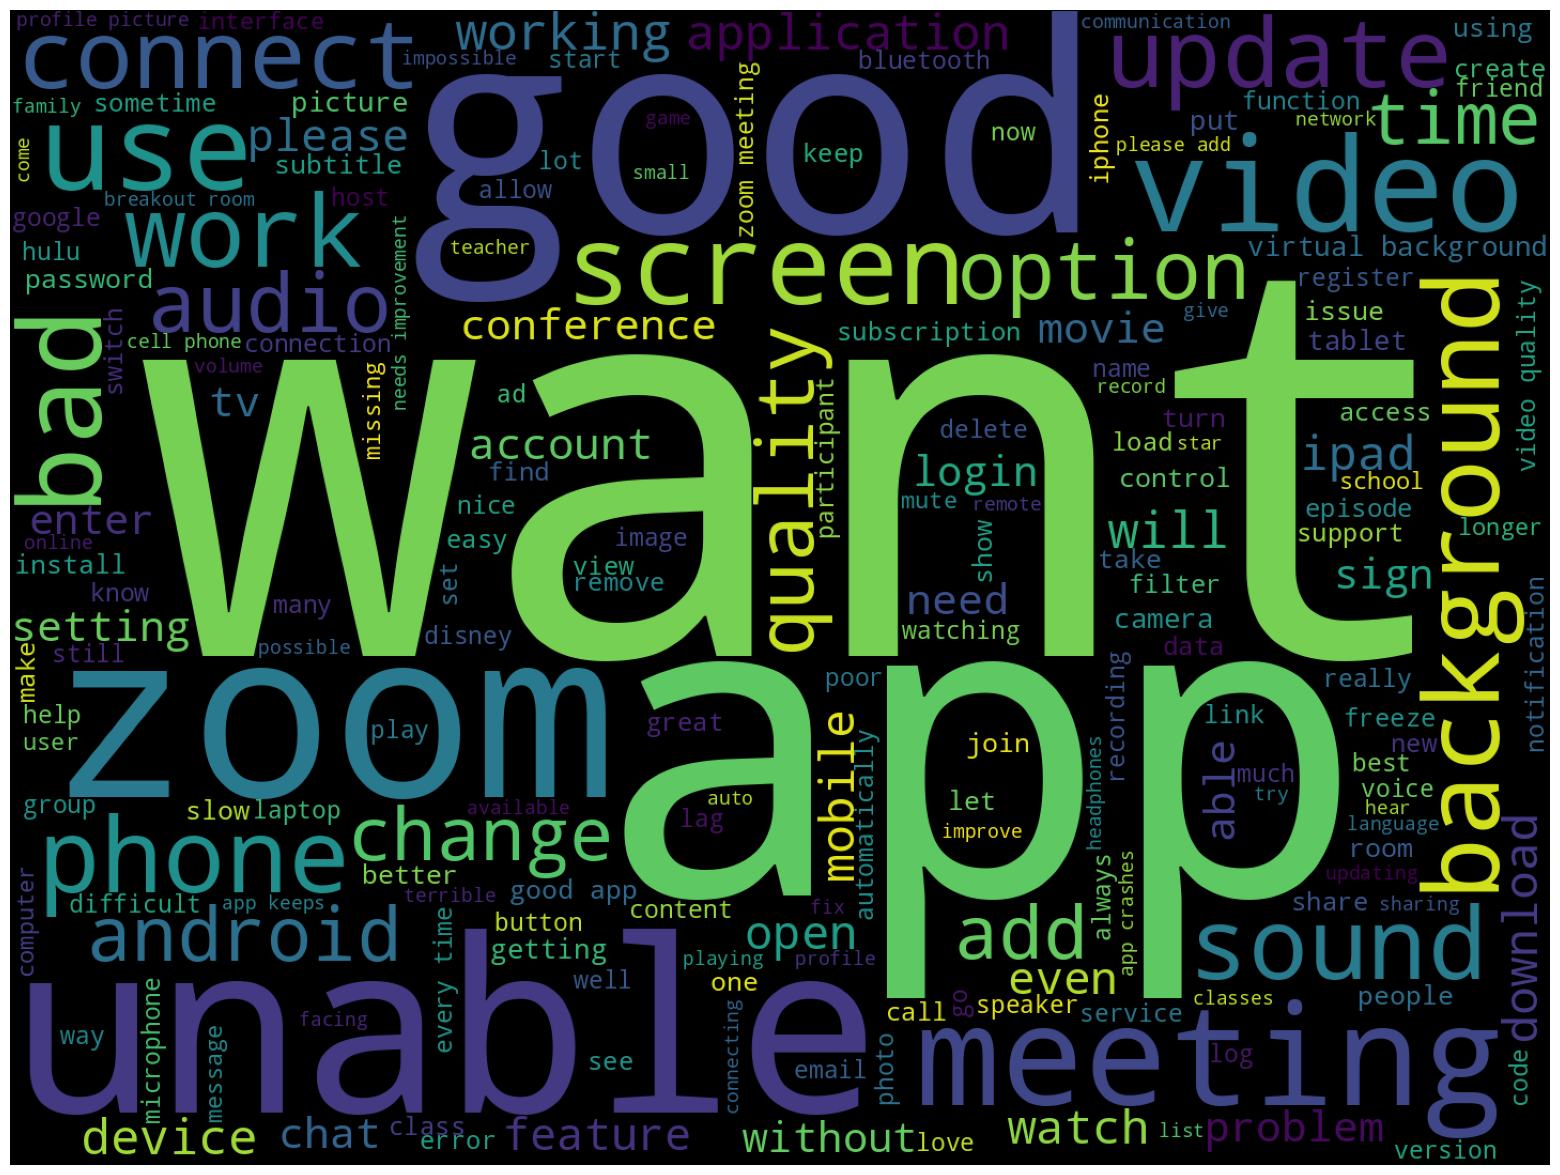

In [66]:
cloud = WordCloud(
    width=1440, height=1080
).generate(" ".join(all_train_text.astype(str)))

plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [67]:
all_test_text = pd.Series(evaluation_data['text'].to_list() + 
                  evaluation_data['reason'].to_list()).astype(str)

(-0.5, 1439.5, 1079.5, -0.5)

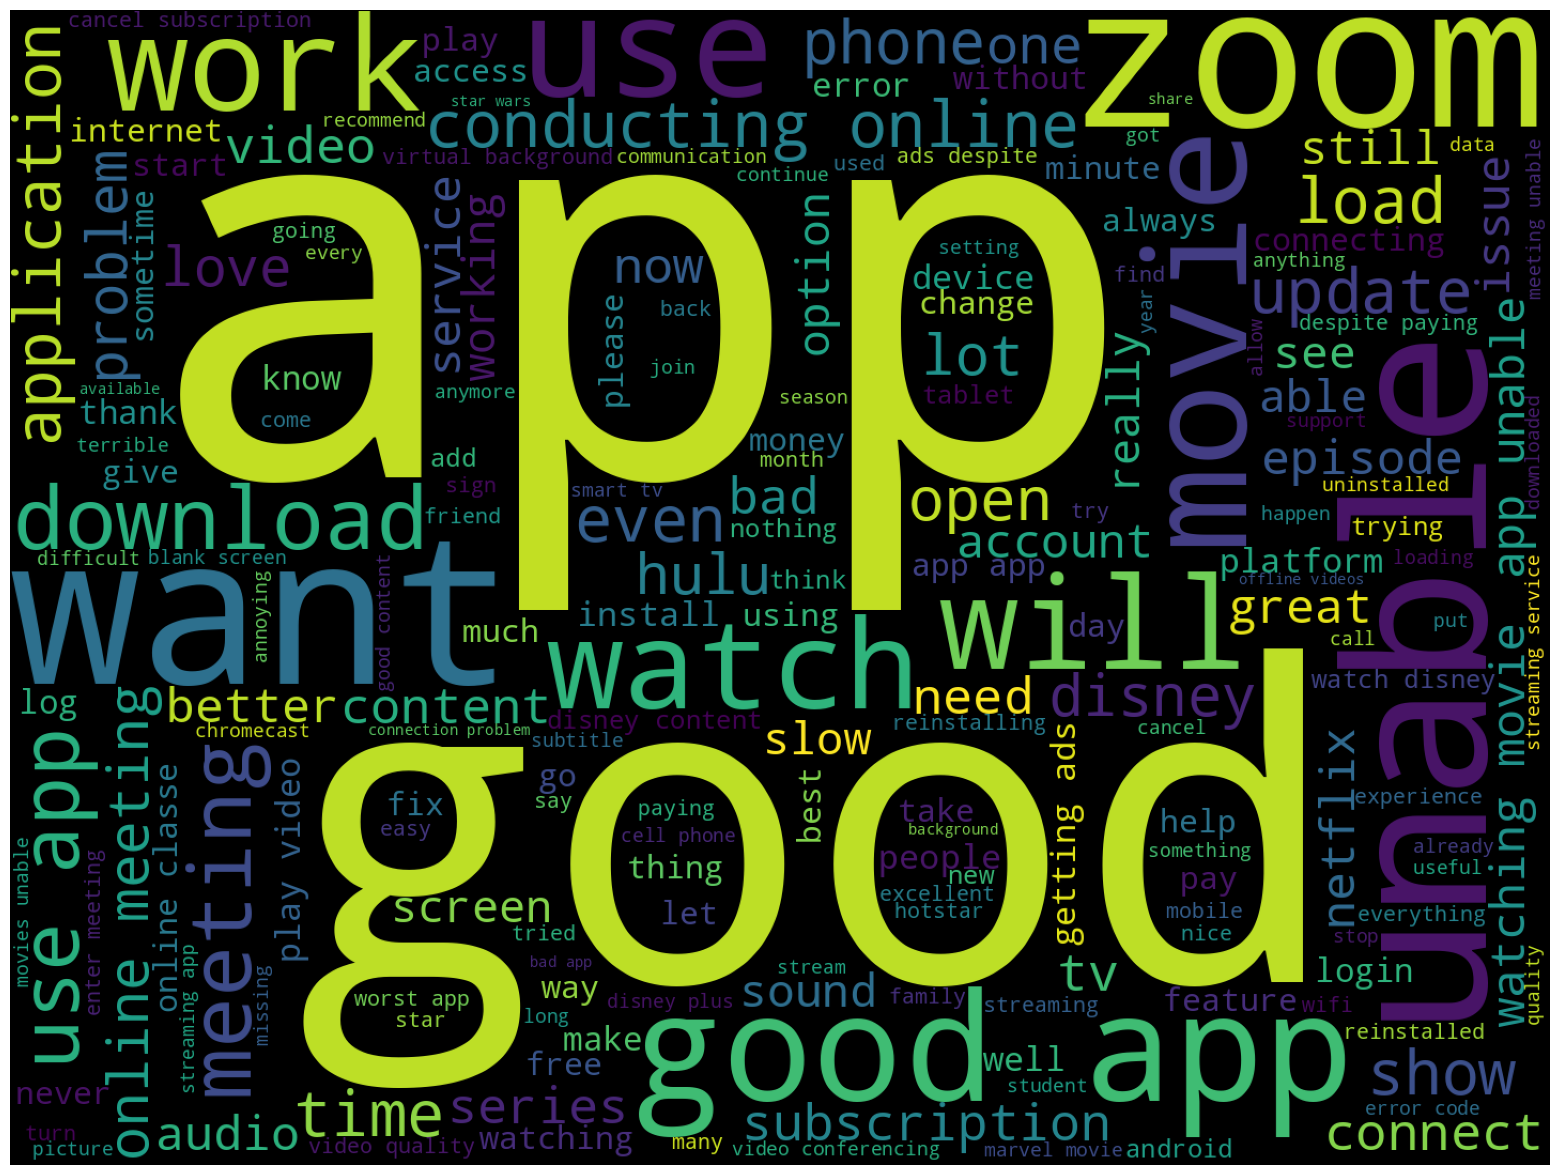

In [68]:
cloud = WordCloud(
    width=1440, height=1080
).generate(" ".join(all_test_text.astype(str)))

plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [69]:
td = train_data
ed = evaluation_data

td = pd.DataFrame(
    train_data['text'].to_list() + train_data['reason'].to_list(), 
columns=['text']).astype(str)

In [70]:
ed = pd.DataFrame(
    evaluation_data['text'].to_list() + evaluation_data['reason'].to_list(), 
columns=['text']).astype(str)

In [71]:
td['train_word_len'] = td['text'].apply(lambda x : len(x.split()))
td['eval_word_len'] = ed['text'].apply(lambda x : len(x.split()))

In [72]:
px.histogram(
    td, x="train_word_len",
    height=700, 
    color='eval_word_len', 
    title="Question1 Length Distribution", marginal="box")

In [73]:
px.histogram(
    train_data, 
    x="text",height=700, color='label', title="reason", marginal="box")

In [100]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['text']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['reason']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

Text(0.5, 0, 'word_match_share')

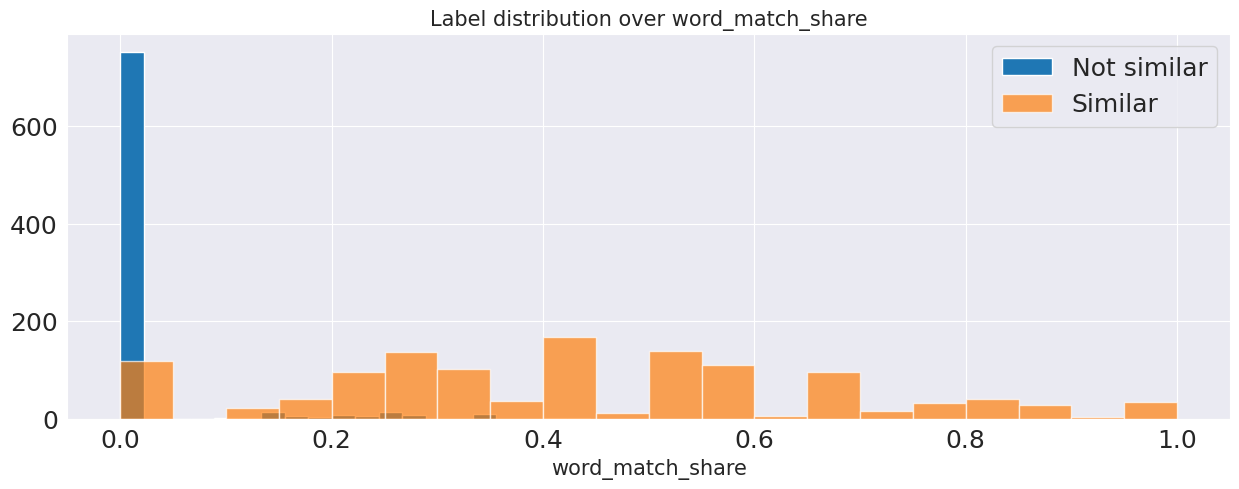

In [112]:
plt.figure(figsize=(15, 5))
train_word_match = train_data.apply(word_match_share, axis=1)
plt.hist(train_word_match[train_data['label'] == 0], bins=20, label='Not similar')
plt.hist(train_word_match[train_data['label'] == 1], bins=20, alpha=0.7, label='Similar')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

### **This means the evaluation data's feature does not have the power to seperate between similar and dis-similar text-reason pair**

# Using TF-IDF

In [113]:


def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['text']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['reason']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [103]:
es = pd.Series(
    evaluation_data['text'].to_list() + evaluation_data['reason'].to_list()).astype(str)

In [104]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(es)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

Text(0.5, 0, 'word_match_share')

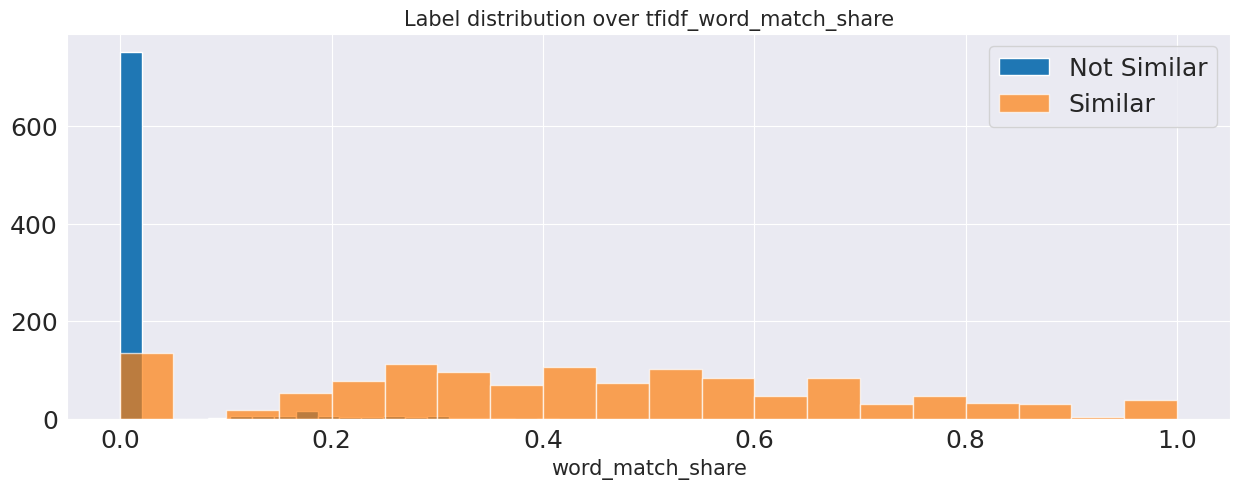

In [114]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = train_data.apply(tfidf_word_match_share, axis=1)
plt.hist(tfidf_train_word_match[train_data['label'] == 0].fillna(0), bins=20, label='Not Similar')
plt.hist(tfidf_train_word_match[train_data['label'] == 1].fillna(0), bins=20, alpha=0.7, label='Similar')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

### **Even using TF-IDF also, it is not able to differ between similar and not similar**

In [115]:
x_train = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match

In [116]:
x_test = pd.DataFrame()
x_test['word_match'] = evaluation_data.apply(word_match_share, axis=1)
x_test['tfidf_word_match'] = evaluation_data.apply(tfidf_word_match_share, axis=1)

In [117]:
y_train = train_data['label'].values
y_test = evaluation_data['label'].values

In [119]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.18646367199276453


In [120]:
pos_test = x_test[y_test == 1]
neg_test = x_test[y_test == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_test) / (len(pos_test) + len(neg_test))) / p) - 1
while scale > 1:
    neg_test = pd.concat([neg_test, neg_test])
    scale -=1
neg_test = pd.concat([neg_test, neg_test[:int(scale * len(neg_test))]])
print(len(pos_test) / (len(pos_test) + len(neg_test)))

x_train = pd.concat([pos_test, neg_test])
y_train = (np.zeros(len(pos_test)) + 1).tolist() + np.zeros(len(neg_test)).tolist()
del pos_test, neg_test

0.1967997901501738


In [130]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_test, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 2000, watchlist, verbose_eval=10)

[0]	train-logloss:0.68778	test-logloss:0.68778
[10]	train-logloss:0.64649	test-logloss:0.64649
[20]	train-logloss:0.62141	test-logloss:0.62141
[30]	train-logloss:0.60667	test-logloss:0.60667
[40]	train-logloss:0.59862	test-logloss:0.59862
[50]	train-logloss:0.59487	test-logloss:0.59487
[60]	train-logloss:0.59387	test-logloss:0.59387
[70]	train-logloss:0.59455	test-logloss:0.59455
[80]	train-logloss:0.59617	test-logloss:0.59617
[90]	train-logloss:0.59833	test-logloss:0.59833
[100]	train-logloss:0.60060	test-logloss:0.60060
[110]	train-logloss:0.60292	test-logloss:0.60292
[120]	train-logloss:0.60502	test-logloss:0.60502
[130]	train-logloss:0.60684	test-logloss:0.60684
[140]	train-logloss:0.60847	test-logloss:0.60847
[150]	train-logloss:0.60970	test-logloss:0.60970
[160]	train-logloss:0.61047	test-logloss:0.61047
[170]	train-logloss:0.61127	test-logloss:0.61127
[180]	train-logloss:0.61176	test-logloss:0.61176
[190]	train-logloss:0.61226	test-logloss:0.61226
[200]	train-logloss:0.61258	tes

[1670]	train-logloss:0.57490	test-logloss:0.57490
[1680]	train-logloss:0.57479	test-logloss:0.57479
[1690]	train-logloss:0.57471	test-logloss:0.57471
[1700]	train-logloss:0.57461	test-logloss:0.57461
[1710]	train-logloss:0.57456	test-logloss:0.57456
[1720]	train-logloss:0.57449	test-logloss:0.57449
[1730]	train-logloss:0.57440	test-logloss:0.57440
[1740]	train-logloss:0.57432	test-logloss:0.57432
[1750]	train-logloss:0.57424	test-logloss:0.57424
[1760]	train-logloss:0.57415	test-logloss:0.57415
[1770]	train-logloss:0.57409	test-logloss:0.57409
[1780]	train-logloss:0.57396	test-logloss:0.57396
[1790]	train-logloss:0.57390	test-logloss:0.57390
[1800]	train-logloss:0.57382	test-logloss:0.57382
[1810]	train-logloss:0.57376	test-logloss:0.57376
[1820]	train-logloss:0.57365	test-logloss:0.57365
[1830]	train-logloss:0.57359	test-logloss:0.57359
[1840]	train-logloss:0.57354	test-logloss:0.57354
[1850]	train-logloss:0.57348	test-logloss:0.57348
[1860]	train-logloss:0.57340	test-logloss:0.57340


In [135]:
x_test = pd.DataFrame()
x_test['word_match'] = evaluation_data.apply(word_match_share, axis=1)
x_test['tfidf_word_match'] = evaluation_data.apply(tfidf_word_match_share, axis=1)
d_test = xgb.DMatrix(x_test)

predictions = bst.predict(d_test)

In [143]:
preds = []
for pred in predictions:
    preds.append(
        0 if pred < 0.5 else 1
    )

In [144]:
preds = np.array(preds)

In [147]:
(preds == y_test).sum() / len(y_test)

0.7246666666666667

In [148]:
preds

array([0, 0, 0, ..., 0, 0, 0])

### Getting precision, recall and cf for all the approaches